In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import weightedstats as ws
import scipy.integrate as integrate
from scipy import stats

In [33]:
#-----------------------------------------------------------------------
# Priors
#-----------------------------------------------------------------------
Mabs = -19.41
H_0 = 73.50
Omega_m0 = 0.33
Omega_k0 = 0.

# Physical parameters
cv = 299792.0 # km/s

# Dispersions
sigintmb = 0.1 # Intrinsic dispersion
sigmicro = 0.3 # Dispersion in log10(mu_micro)

# Magnitude and redshift limit
maglim = 21.
absmaglim = -19.5
zlcut = 0.15

# Magnification limit
maxmag = 400.
mulim = 10.
mulim2 = 20.
mulim3 = 30.

disconv = 0.0279840 # converts delta t in days, distances in Mpc and angles in arcsec 

In [3]:
#-----------------------------------------------------------------------
# Define necessary cosmological functions
#-----------------------------------------------------------------------
# Normalized Hubble parameter
def E(z, Omega_m0, Omega_k0):    
    return np.sqrt(Omega_m0*(1.0 + z)**3 + Omega_k0*(1.0 + z)**2 + 1.0 - Omega_m0 - Omega_k0)
# Integral of 1/E(z)
def I(z1, z2, Omega_m0, Omega_k0):    
    return integrate.quad(lambda z: 1.0/np.sqrt(Omega_m0*(1.0 + z)**3 + Omega_k0*(1.0 + z)**2 
                                                + 1.0 - Omega_m0 - Omega_k0), z1, z2)[0]
I = np.vectorize(I)

# Luminosity distance
def D_L(z, H_0, Omega_m0, Omega_k0):  
    if Omega_k0 == 0.:
        return cv / H_0 * (1.0 + z) * I(0., z, Omega_m0, Omega_k0)  # Mpc
    if Omega_k0 < 0.:
        return cv / H_0 * (1.0 + z) / np.sqrt(-Omega_k0) * np.sin(np.sqrt(-Omega_k0) * 
                   I(0., z, Omega_m0, Omega_k0))  # Mpc
    if Omega_k0 > 0.:
        return cv / H_0 * (1.0 + z) / np.sqrt(Omega_k0) * np.sinh(np.sqrt(Omega_k0) * 
                   I(0., z, Omega_m0, Omega_k0))  # Mpc    

# Angular distance
def D_A(z0, z1, H_0, Omega_m0, Omega_k0):  
    if Omega_k0 == 0.:
        return cv / H_0 / (1.0 + z1) * I(z0, z1, Omega_m0, Omega_k0)  # Mpc
    if Omega_k0 < 0.:
        return cv / H_0 / (1.0 + z1) / np.sqrt(-Omega_k0) * np.sin(np.sqrt(-Omega_k0) * 
                   I(z0, z1, Omega_m0, Omega_k0))  # Mpc
    if Omega_k0 > 0.:
        return cv / H_0 / (1.0 + z1) / np.sqrt(Omega_k0) * np.sinh(np.sqrt(Omega_k0) * 
                   I(z0, z1, Omega_m0, Omega_k0))  # Mpc    

In [4]:
mb = 5.0*np.log10(D_L(0.05, H_0, Omega_m0, Omega_k0)) + 25.0 + Mabs
print(mb)

17.21620506497049


In [5]:
df = pd.read_csv('df_DG_sneIa_skysurvey.csv')
'''
'sntype': it shows nan, but it doesnt matter, they are all Ias anyways, 
't0', 'mb', 'amplitude', 'ebvhost', 'ra', 'dec', 'ebvmw',
'zs': redshift of the zourse, 
'imno': multiplicity, 
'zl': redshift of the lens, 
'mu_total': total magnification, 
'td_max': max time delay, 
'td_med': median time delay, 
'angsep_max': max angular separation in arcsec,
'angsep_med': median angular separation in arcsec,
'td_ind': time delay of the individual images, 
'mu_ind': magnification of the individual images, 
'weights': weights for the distributions. 
'''
print(np.shape(df))
nsn = len(df)

(318818, 19)


In [6]:
mbvec = 5.0*np.log10(D_L(df.zs, H_0, Omega_m0, Omega_k0)) + 25.0 + Mabs
mulens = 5.0*np.log10(D_L(df.zl, H_0, Omega_m0, Omega_k0)) + 25.0

In [7]:
dmbintvec = np.random.normal(loc = 0.0, scale = sigintmb, size = nsn)
dmbmagint = -2.5*np.log10(df.mu_total)
dmbmicrolens = np.random.normal(loc = 0.0, scale = 2.5*sigmicro*np.sqrt(df.imno), size = nsn)

In [8]:
dmbtot = dmbintvec + dmbmagint + dmbmicrolens

In [9]:
mbtot = mbvec + dmbtot
mabslenstot = mbtot - mulens

In [10]:
indmabsbright = np.array(np.where(mabslenstot < absmaglim))[0,:]
indmabsfaint = np.array(np.where(mabslenstot > absmaglim))[0,:]

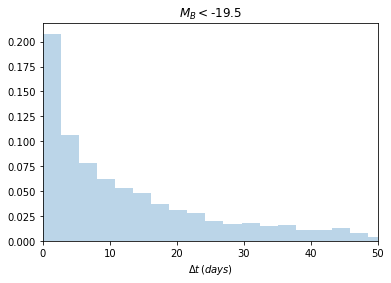

Number of SNe:  55337
Median time delay:  9.680727133589071 days


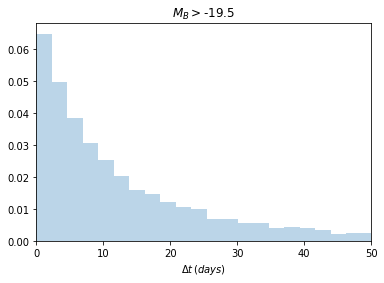

Number of SNe:  263481
Median time delay:  9.493795027318264 days


In [17]:
nbins = 100
plt.hist(df.td_max[indmabsbright], bins=nbins, weights=df.weights[indmabsbright], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim))
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Number of SNe: ', len(indmabsbright))
print('Median time delay: ',ws.weighted_median(df.td_max[indmabsbright], weights = df.weights[indmabsbright]), 'days')

nbins = 100
plt.hist(df.td_max[indmabsfaint], bins=nbins, weights=df.weights[indmabsfaint], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim))
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Number of SNe: ', len(indmabsfaint))
print('Median time delay: ',ws.weighted_median(df.td_max[indmabsfaint], weights = df.weights[indmabsfaint]), 'days')

In [34]:
indmabsbrightsel = np.array(np.where((mabslenstot < absmaglim) & (df.zl > zlcut) & 
                                     (mbtot < maglim) & (df.mu_total < maxmag)))[0,:]
indmabsfaintsel = np.array(np.where((mabslenstot > absmaglim) & (df.zl > zlcut) & 
                                    (mbtot < maglim) & (df.mu_total < maxmag)))[0,:]

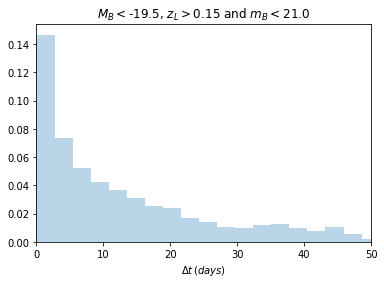

Number of SNe:  15880
Median time delay:  9.587128576545682 days


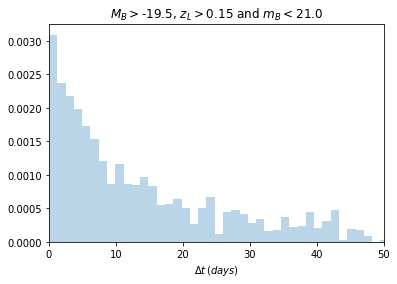

Number of SNe:  2712
Median time delay:  10.744092258962644 days


In [35]:
nbins = 100
plt.hist(df.td_max[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Number of SNe: ', len(indmabsbrightsel))
print('Median time delay: ',ws.weighted_median(df.td_max[indmabsbrightsel], weights = df.weights[indmabsbrightsel]), 'days')

nbins = 100
plt.hist(df.td_max[indmabsfaintsel], bins=nbins, weights=df.weights[indmabsfaintsel], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Number of SNe: ', len(indmabsfaintsel))
print('Median time delay: ',ws.weighted_median(df.td_max[indmabsfaintsel], weights = df.weights[indmabsfaintsel]), 'days')

In [36]:
mbtestvec = np.array([18.5, 19, 20, 21])
zltestvec = np.array([0.1, 0.15, 0.2, 0.25])
mabstestvec = np.array([-19.5, -20, -20.5, -21])

allsnefac = 1.e2/np.sum(df.weights) # Percentage of entire sample

for i in range(len(mbtestvec)):
    for j in range(len(zltestvec)):
        for k in range(len(mabstestvec)):
            print('m_B < '+str(mbtestvec[i])+', '+'z_L > '+str(zltestvec[j])+', '+'M_B < '+str(mabstestvec[k])+', ', 
                  np.sum(df.weights[np.array(np.where((mbtot < mbtestvec[0]) & 
                        (df.zl >zltestvec[j]) & (mabslenstot < mabstestvec[k])))[0,:]])*allsnefac, '%')

m_B < 18.5, z_L > 0.1, M_B < -19.5,  21.22403808357307 %
m_B < 18.5, z_L > 0.1, M_B < -20.0,  21.161512735882276 %
m_B < 18.5, z_L > 0.1, M_B < -20.5,  20.744792542893457 %
m_B < 18.5, z_L > 0.1, M_B < -21.0,  20.129978497556593 %
m_B < 18.5, z_L > 0.15, M_B < -19.5,  19.20899590578542 %
m_B < 18.5, z_L > 0.15, M_B < -20.0,  19.20899590578542 %
m_B < 18.5, z_L > 0.15, M_B < -20.5,  19.20899590578542 %
m_B < 18.5, z_L > 0.15, M_B < -21.0,  19.10126033958216 %
m_B < 18.5, z_L > 0.2, M_B < -19.5,  17.34299395838205 %
m_B < 18.5, z_L > 0.2, M_B < -20.0,  17.34299395838205 %
m_B < 18.5, z_L > 0.2, M_B < -20.5,  17.34299395838205 %
m_B < 18.5, z_L > 0.2, M_B < -21.0,  17.34299395838205 %
m_B < 18.5, z_L > 0.25, M_B < -19.5,  15.42589449615075 %
m_B < 18.5, z_L > 0.25, M_B < -20.0,  15.42589449615075 %
m_B < 18.5, z_L > 0.25, M_B < -20.5,  15.42589449615075 %
m_B < 18.5, z_L > 0.25, M_B < -21.0,  15.42589449615075 %
m_B < 19.0, z_L > 0.1, M_B < -19.5,  21.22403808357307 %
m_B < 19.0, z_L > 0.

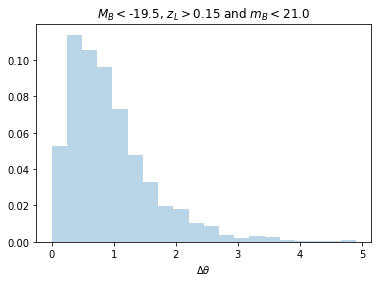

Median image separation:  0.7973076498616438


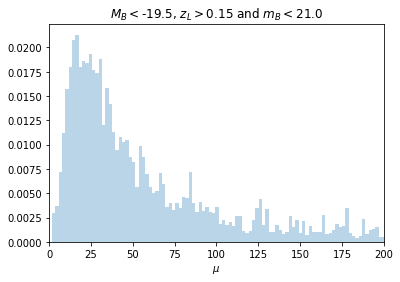

Median magnification:  42.13491538444559


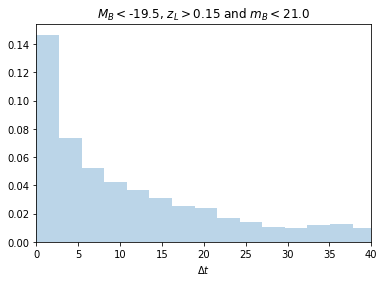

Median time delay:  9.587128576545682


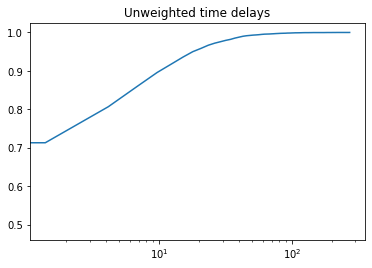

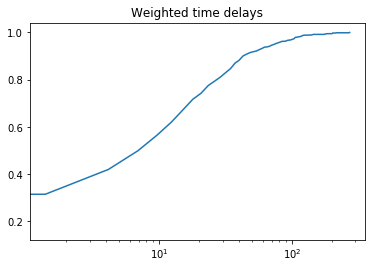

In [37]:
nbins = 20 
plt.hist(df.angsep_max[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta\theta$')
#plt.xlim([0,50])
plt.show()
print('Median image separation: ', 
      ws.weighted_median(df.angsep_max[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

nbins = 200 
plt.hist(df.mu_total[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\mu$')
plt.xlim([0,200])
plt.show()
print('Median magnification: ', 
      ws.weighted_median(df.mu_total[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

nbins = 100 
plt.hist(df.td_max[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta t$')
plt.xlim([0,40])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

res = stats.cumfreq(df.td_max[indmabsbrightsel], numbins=100, defaultreallimits=None, weights=None)
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.title('Unweighted time delays')
plt.show()

res = stats.cumfreq(df.td_max[indmabsbrightsel], numbins=100, defaultreallimits=None, weights=df.weights[indmabsbrightsel])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.title('Weighted time delays')
plt.show()

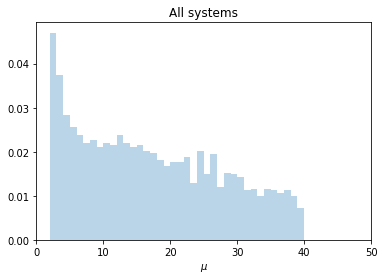

Median macro magnification:  30.31646413918605


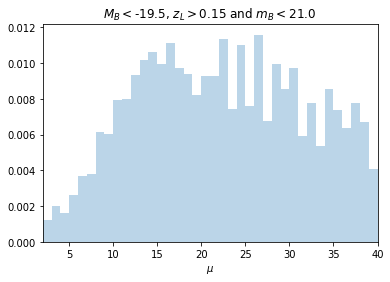

Median macro magnification:  42.13491538444559


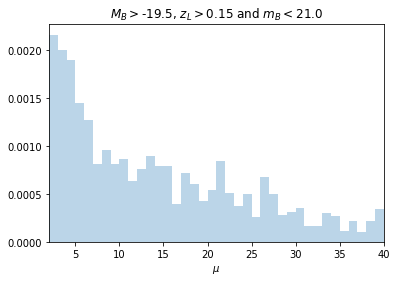

Median macro magnification:  15.161227038645247


In [39]:
binwidth = 1
mumin = 2
mumax = 40
mubins = np.arange(mumin, mumax + binwidth, binwidth)
#print(mubins)

plt.hist(df.mu_total, bins=mubins, weights=df.weights, alpha=0.3)
plt.title('All systems')
plt.xlabel(r'$\mu$')
plt.xlim([0,50])
plt.show()
print('Median macro magnification: ',ws.weighted_median(df.mu_total, weights = df.weights))

plt.hist(df.mu_total[indmabsbrightsel], bins=mubins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\mu$')
plt.xlim([mumin,mumax])
plt.show()
print('Median macro magnification: ',
      ws.weighted_median(df.mu_total[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

plt.hist(df.mu_total[indmabsfaintsel], bins=mubins, weights=df.weights[indmabsfaintsel], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\mu$')
plt.xlim([mumin,mumax])
plt.show()
print('Median macro magnification: ',
      ws.weighted_median(df.mu_total[indmabsfaintsel], weights = df.weights[indmabsfaintsel]))

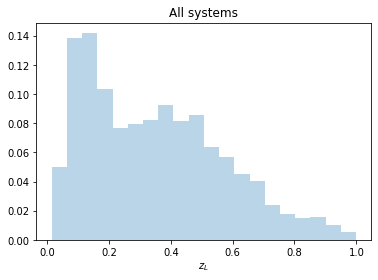

Median lens redshift:  0.3247877025628434


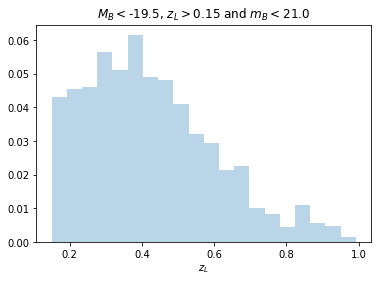

Median lens redshift:  0.396422826547736


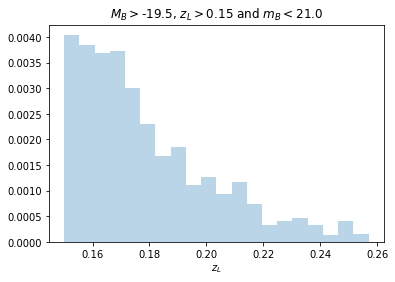

Median lens redshift:  0.1725730032414882


In [40]:
nbins = 20 
plt.hist(df.zl, bins=nbins, weights=df.weights, alpha=0.3)
plt.title('All systems')
plt.xlabel(r'$z_L$')
#plt.xlim([0,50])
plt.show()
print('Median lens redshift: ', ws.weighted_median(df.zl, weights = df.weights))

nbins = 20 
plt.hist(df.zl[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$z_L$')
#plt.xlim([0,50])
plt.show()
print('Median lens redshift: ', 
      ws.weighted_median(df.zl[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

nbins = 20 
plt.hist(df.zl[indmabsfaintsel], bins=nbins, weights=df.weights[indmabsfaintsel], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$z_L$')
#plt.xlim([0,50])
plt.show()
print('Median lens redshift: ', ws.weighted_median(df.zl[indmabsfaintsel], weights = df.weights[indmabsfaintsel]))

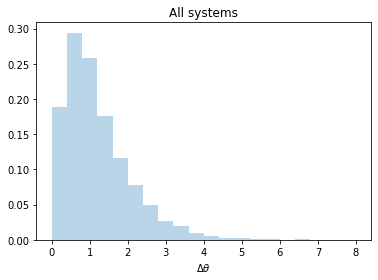

Median image separation:  0.9947223637967186


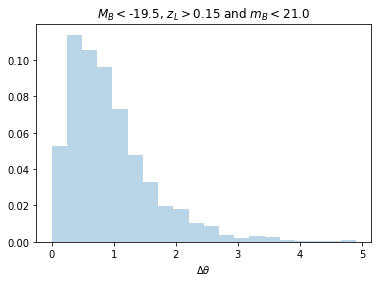

Median image separation:  0.7973076498616438


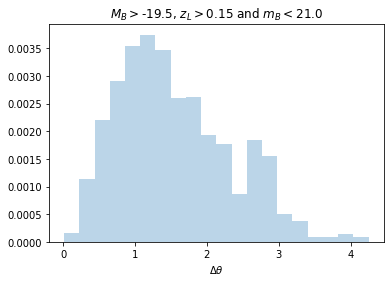

Median image separation:  1.406203199724853


In [41]:
nbins = 20 
plt.hist(df.angsep_max, bins=nbins, weights=df.weights, alpha=0.3)
plt.title('All systems')
plt.xlabel(r'$\Delta\theta$')
#plt.xlim([0,50])
plt.show()
print('Median image separation: ', ws.weighted_median(df.angsep_max, weights = df.weights))

nbins = 20 
plt.hist(df.angsep_max[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta\theta$')
#plt.xlim([0,50])
plt.show()
print('Median image separation: ', 
      ws.weighted_median(df.angsep_max[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

nbins = 20 
plt.hist(df.angsep_max[indmabsfaintsel], bins=nbins, weights=df.weights[indmabsfaintsel], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta\theta$')
#plt.xlim([0,50])
plt.show()
print('Median image separation: ', 
      ws.weighted_median(df.angsep_max[indmabsfaintsel], weights = df.weights[indmabsfaintsel]))

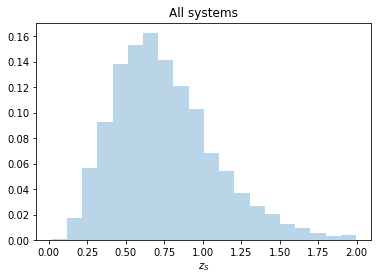

Median source redshift:  0.7078560364447353


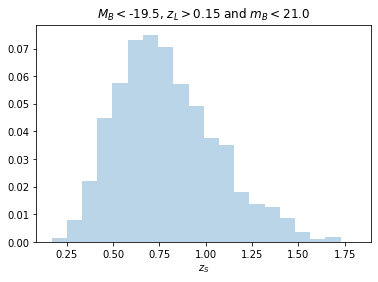

Median source redshift:  0.7585880554649216


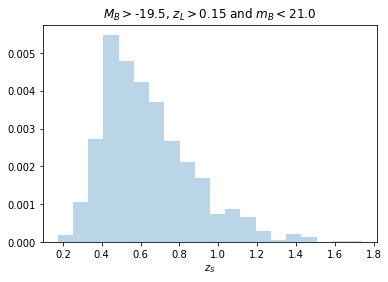

Median source redshift:  0.5913620019429404


In [42]:
nbins = 20 
plt.hist(df.zs, bins=nbins, weights=df.weights, alpha=0.3)
plt.title('All systems')
plt.xlabel(r'$z_S$')
#plt.xlim([0,50])
plt.show()
print('Median source redshift: ', ws.weighted_median(df.zs, weights = df.weights))

nbins = 20 
plt.hist(df.zs[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$z_S$')
#plt.xlim([0,50])
plt.show()
print('Median source redshift: ', 
      ws.weighted_median(df.zs[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

nbins = 20 
plt.hist(df.zs[indmabsfaintsel], bins=nbins, weights=df.weights[indmabsfaintsel], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$z_S$')
#plt.xlim([0,50])
plt.show()
print('Median source redshift: ', ws.weighted_median(df.zs[indmabsfaintsel], weights = df.weights[indmabsfaintsel]))

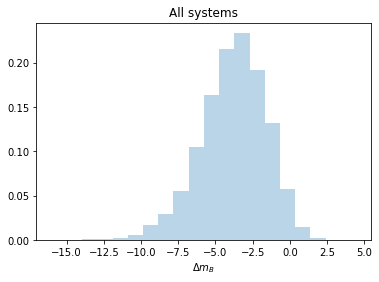

Median magnitude shift:  -3.6566371696405464


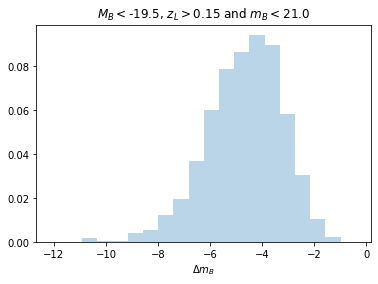

Median magnitude shift:  -4.550540367275883


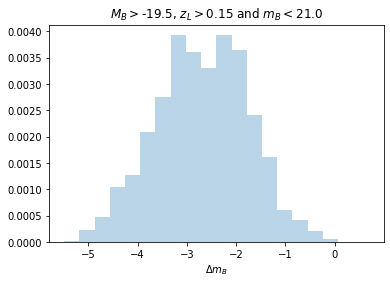

Median magnitude shift:  -2.6822238525723296


In [43]:
nbins = 20 
plt.hist(dmbtot, bins=nbins, weights=df.weights, alpha=0.3)
plt.title('All systems')
plt.xlabel(r'$\Delta m_B$')
#plt.xlim([0,50])
plt.show()
print('Median magnitude shift: ', ws.weighted_median(dmbtot, weights = df.weights))

nbins = 20 
plt.hist(dmbtot[indmabsbrightsel], bins=nbins, weights=df.weights[indmabsbrightsel], alpha=0.3)
plt.title(r'$M_B <$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta m_B$')
#plt.xlim([0,50])
plt.show()
print('Median magnitude shift: ', 
      ws.weighted_median(dmbtot[indmabsbrightsel], weights = df.weights[indmabsbrightsel]))

nbins = 20 
plt.hist(dmbtot[indmabsfaintsel], bins=nbins, weights=df.weights[indmabsfaintsel], alpha=0.3)
plt.title(r'$M_B >$'+str(absmaglim)+', '+r'$z_L >$'+str(zlcut)+' and '+r'$m_B <$'+str(maglim))
plt.xlabel(r'$\Delta m_B$')
#plt.xlim([0,50])
plt.show()
print('Median magnitude shift: ', 
      ws.weighted_median(dmbtot[indmabsfaintsel], weights = df.weights[indmabsfaintsel]))

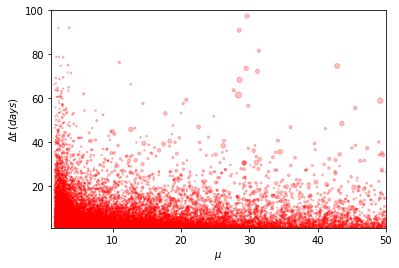

In [17]:
plt.scatter(df.mu_total[indbright], df.td_max[indbright], s=np.sqrt(df.weights[indbright])*1.e3, c='r', marker='o', alpha=0.25)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\Delta t \, (days)$')
plt.xlim([1,50])
plt.ylim([1,100])
plt.show()

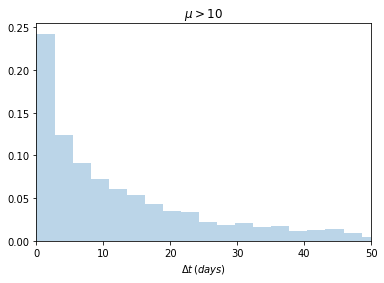

Median time delay:  9.525841625654836 days


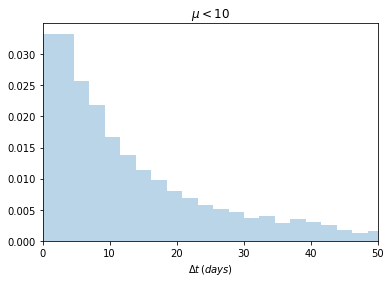

Median time delay:  9.914591153281624 days


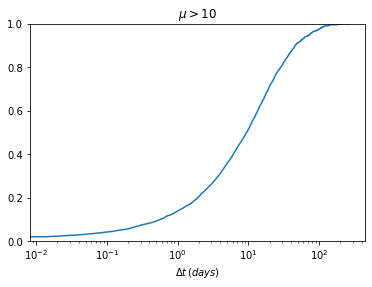

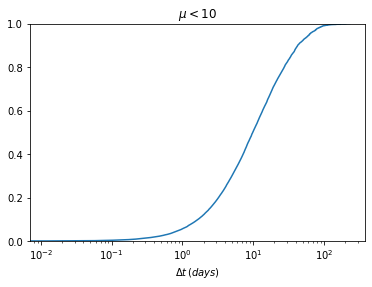

In [44]:
indmularge = np.array(np.where(df.mu_total > mulim))[0,:]
indmusmall = np.array(np.where(df.mu_total < mulim))[0,:]

nbins = 100
plt.hist(df.td_max[indmularge], bins=nbins, weights=df.weights[indmularge], alpha=0.3)
plt.title(r'$\mu > 10$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmularge], weights = df.weights[indmularge]), 'days')

nbins = 100
plt.hist(df.td_max[indmusmall], bins=nbins, weights=df.weights[indmusmall], alpha=0.3)
plt.title(r'$\mu < 10$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmusmall], weights = df.weights[indmusmall]), 'days')

res = stats.cumfreq(df.td_max[indmularge], numbins=10000, defaultreallimits=None, weights=df.weights[indmularge])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.ylim([0,1])
plt.title(r'$\mu > 10$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.show()

res = stats.cumfreq(df.td_max[indmusmall], numbins=10000, defaultreallimits=None, weights=df.weights[indmusmall])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.ylim([0,1])
plt.title(r'$\mu < 10$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.show()

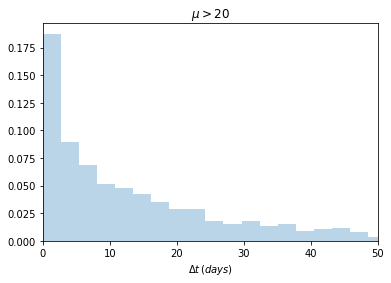

Median time delay:  10.449990267274174 days


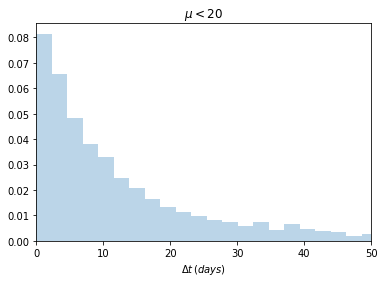

Median time delay:  8.544700366594414 days


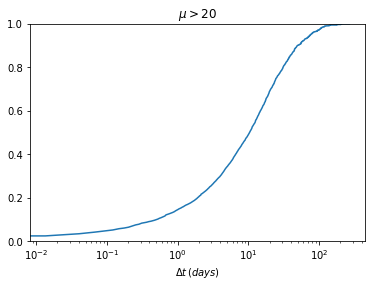

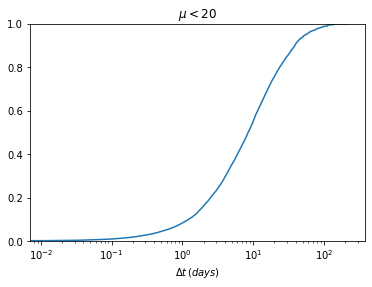

In [19]:
indmularge = np.array(np.where(df.mu_total > mulim2))[0,:]
indmusmall = np.array(np.where(df.mu_total < mulim2))[0,:]

nbins = 100
plt.hist(df.td_max[indmularge], bins=nbins, weights=df.weights[indmularge], alpha=0.3)
plt.title(r'$\mu > 20$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmularge], weights = df.weights[indmularge]), 'days')

nbins = 100
plt.hist(df.td_max[indmusmall], bins=nbins, weights=df.weights[indmusmall], alpha=0.3)
plt.title(r'$\mu < 20$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmusmall], weights = df.weights[indmusmall]), 'days')

res = stats.cumfreq(df.td_max[indmularge], numbins=10000, defaultreallimits=None, weights=df.weights[indmularge])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.ylim([0,1])
plt.title(r'$\mu > 20$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.show()

res = stats.cumfreq(df.td_max[indmusmall], numbins=10000, defaultreallimits=None, weights=df.weights[indmusmall])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.ylim([0,1])
plt.title(r'$\mu < 20$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.show()

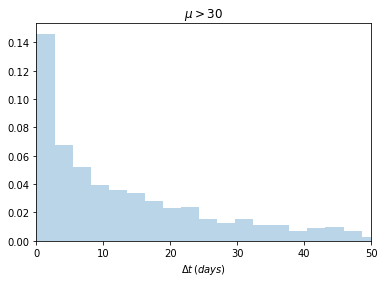

Median time delay:  11.12501935249759 days


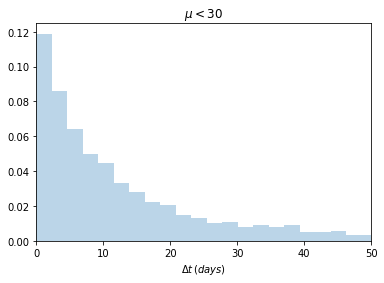

Median time delay:  8.528313118941497 days


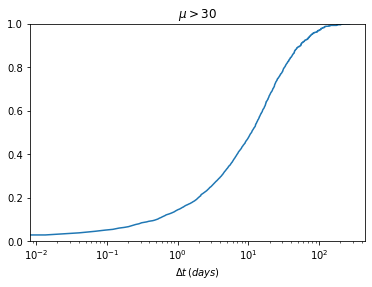

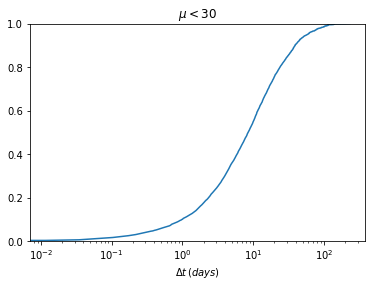

In [20]:
indmularge = np.array(np.where(df.mu_total > mulim3))[0,:]
indmusmall = np.array(np.where(df.mu_total < mulim3))[0,:]

nbins = 100
plt.hist(df.td_max[indmularge], bins=nbins, weights=df.weights[indmularge], alpha=0.3)
plt.title(r'$\mu > 30$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmularge], weights = df.weights[indmularge]), 'days')

nbins = 100
plt.hist(df.td_max[indmusmall], bins=nbins, weights=df.weights[indmusmall], alpha=0.3)
plt.title(r'$\mu < 30$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indmusmall], weights = df.weights[indmusmall]), 'days')

res = stats.cumfreq(df.td_max[indmularge], numbins=10000, defaultreallimits=None, weights=df.weights[indmularge])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.ylim([0,1])
plt.title(r'$\mu > 30$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.show()

res = stats.cumfreq(df.td_max[indmusmall], numbins=10000, defaultreallimits=None, weights=df.weights[indmusmall])
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount/np.max(res.cumcount))
plt.xscale('log')
plt.ylim([0,1])
plt.title(r'$\mu < 30$')
plt.xlabel(r'$\Delta t \, (days)$')
plt.show()

In [21]:
zsmin = 0.38
zsmax = 0.42
indzs = np.array(np.where((df.zs > zsmin) & (df.zs < zsmax)))[0,:]

In [22]:
dl = D_A(0.0, df.zl[indzs], H_0, Omega_m0, Omega_k0)
ds = D_A(0.0, df.zs[indzs], H_0, Omega_m0, Omega_k0)
dls = D_A(df.zl[indzs], df.zs[indzs], H_0, Omega_m0, Omega_k0)
deltdis = dl*dls/ds*(1+df.zl[indzs])
dtproxy = disconv*df.angsep_max[indzs]**2/df.mu_total[indzs]*ds*dl/dls*(1+df.zl[indzs])

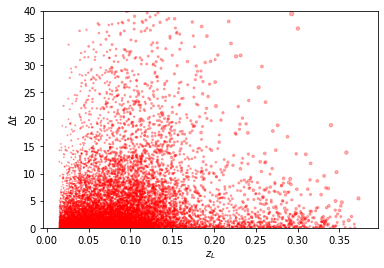

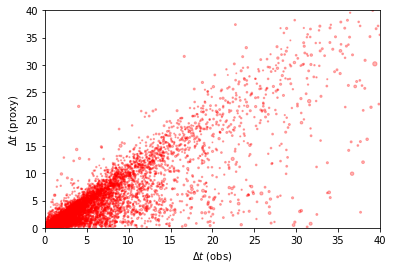

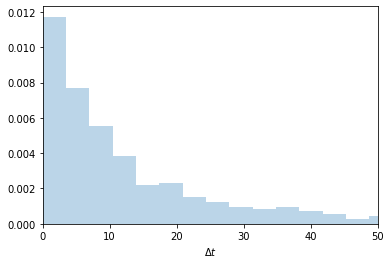

Median time delay:  7.925525546687494 days


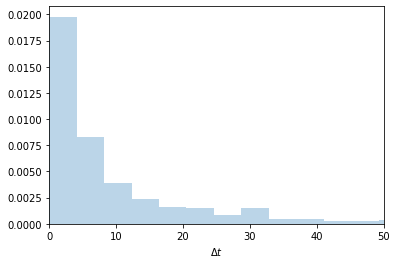

Median time delay:  4.747120626025053 days


In [23]:
plt.scatter(df.zl[indzs], df.td_max[indzs], s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.xlabel(r'$z_L$')
plt.ylabel(r'$\Delta t$')
plt.ylim([0,40])
#plt.ylabel(r'$\Delta t = D_L\cdot D_{LS}/D_S\cdot (1+z_L)$')
plt.show()

plt.scatter(df.td_max[indzs], dtproxy, s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.xlabel(r'$\Delta t$ (obs)')
plt.ylabel(r'$\Delta t$ (proxy)')
plt.xlim([0,40])
plt.ylim([0,40])
#plt.ylabel(r'$\Delta t = D_L\cdot D_{LS}/D_S\cdot (1+z_L)$')
plt.show()

nbins = 50
plt.hist(df.td_max[indzs], bins=nbins, weights=df.weights[indzs], alpha=0.3)
plt.xlabel(r'$\Delta t$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indzs], weights = df.weights[indzs]), 'days')

nbins = 50
plt.hist(dtproxy, bins=nbins, weights=df.weights[indzs], alpha=0.3)
plt.xlabel(r'$\Delta t$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(dtproxy, weights = df.weights[indzs]), 'days')

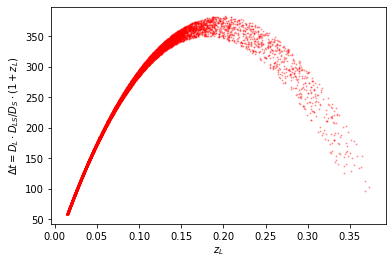

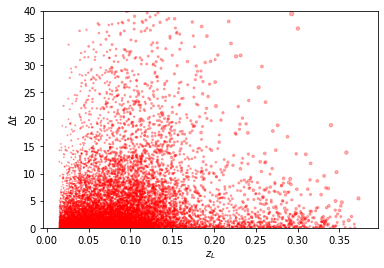

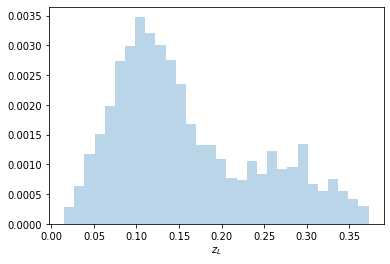

Median lens redshift:  0.1355817938944314


In [24]:
plt.scatter(df.zl[indzs], deltdis, s=1., c='r', marker='o', alpha=0.3)
plt.xlabel(r'$z_L$')
plt.ylabel(r'$\Delta t = D_L\cdot D_{LS}/D_S\cdot (1+z_L)$')
plt.show()

plt.scatter(df.zl[indzs], df.td_max[indzs], s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.ylim([0,40])
plt.xlabel(r'$z_L$')
plt.ylabel(r'$\Delta t$')
plt.show()

nbins = 30
plt.hist(df.zl[indzs], bins=nbins, weights=df.weights[indzs], alpha=0.3)
plt.xlabel(r'$z_L$')
#plt.xlim([0,50])
plt.show()
print('Median lens redshift: ', ws.weighted_median(df.zl[indzs], weights = df.weights[indzs]))

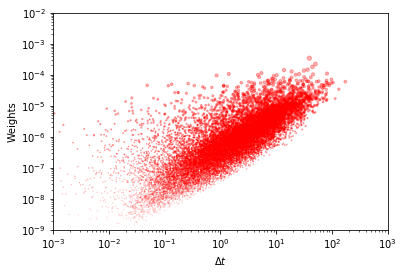

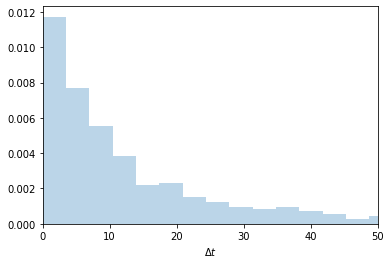

Median time delay:  7.925525546687494 days


In [25]:
plt.scatter(df.td_max[indzs], df.weights[indzs], s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta t$')
plt.ylabel('Weights')
plt.xlim([1.e-3,1.e3])
plt.ylim([1.e-9,1.e-2])
plt.show()

nbins = 50
plt.hist(df.td_max[indzs], bins=nbins, weights=df.weights[indzs], alpha=0.3)
plt.xlabel(r'$\Delta t$')
plt.xlim([0,50])
plt.show()
print('Median time delay: ', ws.weighted_median(df.td_max[indzs], weights = df.weights[indzs]), 'days')

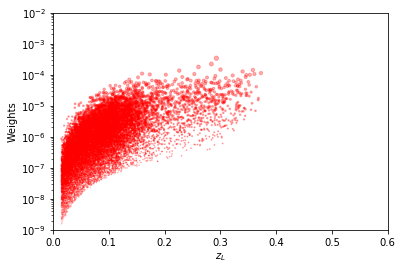

In [26]:
plt.scatter(df.zl[indzs], df.weights[indzs], s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.yscale('log')
plt.xlabel(r'$z_L$')
plt.ylabel('Weights')
plt.xlim([0,0.6])
plt.ylim([1.e-9,1.e-2])
plt.show()

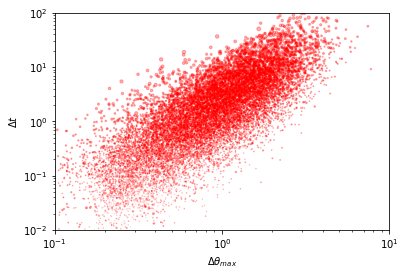

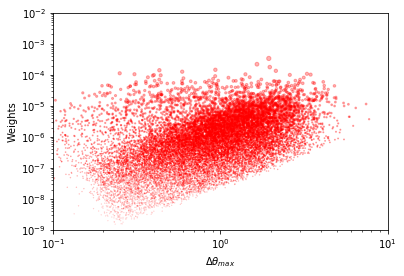

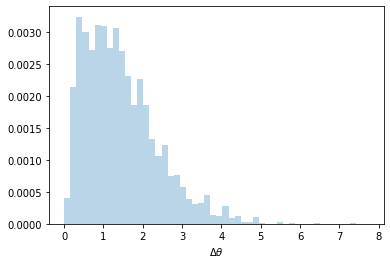

Median image separation:  1.286289419934971 days


In [27]:
plt.scatter(df.angsep_max[indzs], df.td_max[indzs], s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.e-1,1.e1])
plt.ylim([1.e-2,1.e2])
plt.xlabel(r'$\Delta\theta_{max}$')
plt.ylabel(r'$\Delta t$')
plt.show()

plt.scatter(df.angsep_max[indzs], df.weights[indzs], s=np.sqrt(df.weights[indzs])*1.e3, c='r', marker='o', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta\theta_{max}$')
plt.ylabel('Weights')
plt.xlim([1.e-1,1.e1])
plt.ylim([1.e-9,1.e-2])
plt.show()

nbins = 50
plt.hist(df.angsep_max[indzs], bins=nbins, weights=df.weights[indzs], alpha=0.3)
plt.xlabel(r'$\Delta\theta$')
#plt.xlim([0,50])
plt.show()
print('Median image separation: ', ws.weighted_median(df.angsep_max[indzs], weights = df.weights[indzs]), 'days')